In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from lmfit import Model

plt.style.use("ggplot")

# Task 2.5: Estimate retention coefficients

From the proposal text:

> **Oppgave 2.5: Estimer retensjonskoeffisienter**
>
> Det vil bli satt sammen en database over innsjøer hvor både inn- og utløpstilførsler måles. Ved bruk av oppdaterte oppholdstider (Oppgave 2.4) vil retensjon i reginefeltskala estimeres ved å vurdere alle innsjøer langs hovedelvene i hvert nedbørfelt, antatt seriekoblet. Retensjonskoeffisienter for alle parametere (DIN, TON, TDP, TPP, SS og TOC) vil være basert på Vollenweider (1975) konseptet, med parameterspesifikke koeffisienter i utgangspunktet hentet fra litteraturen og deretter raffinert ved hjelp av observerte datasett.
>
> For underfraksjoner av N og P vil tilnærmingen som ble brukt i den opprinnelige TEOTIL-modellen for total N og P gi et utgangspunkt som alternativer (som å kalibrere N separat) kan evalueres mot.

## 1. Modelling retention

According to Vollenweider (1975), the relationship between lake inflow and outflow concentrations for a non-volatile substance is given by

$$C_{lake} = \frac{C_{in}}{1 + \sigma \tau}$$

where $\tau$ is the water residence time and $\sigma$ is a parameter representing the rate of internal cycling and removal. See [here](https://nivanorge.github.io/teotil2/pages/05_retention.html) for a derivation of this (especially equation 7) and also the paper by [Ahlgren et al. (1988)](https://www.researchgate.net/publication/227035110_Empirical_and_Theoretical_Models_of_Phosphorus_Loading_Retention_and_Concentration_Vs_Lake_Trophic_State), which provides a nice historical overview.

In practice, the parameter $\sigma$ is often not constant and the factors controlling its variation are not well understood. In the original Vollenweider papers focusing on phosphorus, the only reasonable predictor of $\sigma$ was found to be a relationship with $\tau$

$$\sigma = \frac{1}{\tau ^ {0.5}}$$

More generally, many papers choose to model $\sigma$ as $k \tau ^m$. Substituting this into the first equation above gives

$$C_{lake} = \frac{C_{in}}{1 + k \tau ^{(1 + m)}}$$

Note, however, that in principle $\sigma$ and $\frac{1}{\tau}$ have the same dimensions, so using a fractional exponent creates some problems with dimensional consistency (although Vollenweider considered this to be an acceptable empirical "shortcut"). 

Given measured data for $C_{lake}$, $C_{in}$ and $\tau$, we therefore usually want to either:

 1. Use the first equation and estimate $\sigma$ as a constant (referred to as *"Option 1"* below), or
 
 2. Model $\sigma$ as a function of $\tau$ and estimate $k$ and $m$ (referred to as *"Option 2"* below)
 
To reduce the dimensionality of the problem, instead of modelling $C_{out}$ as a function of both $C_{in}$ and $\tau$, we can divide by $C_{in}$ to get the transmission factor for each lake, and then fit this as a function of $\tau$ alone (see also the post [here](https://stackoverflow.com/questions/73825528/fitting-a-curve-to-data-inconsistent-results) for some further relevant details).

`lmfit` provides a general approach for fitting non-linear functions. However, when rearranged to give transmission as a function of $\tau$, these equations can also be fitted using simple linear regression

 * For constant $\sigma$ (*Option 1*)

$$\frac{C_{in}}{C_{out}} = \sigma \tau + 1$$

 * For $\sigma$ as a function of $\tau$ (*Option 2*)

$$log \left( \frac{L_{in}}{L_{out}} - 1 \right) = log(k) + (1 + m) log(\tau)$$

I will use `lmfit` here for simplicity, but `statsmodels` might provide slightly richer output.

## 2. Subfractions of N and P

In principle, it is reasonable to use Vollenweider-like approaches to model all of the water quality parameters of interest in TEOTIL. However, there are some additional factors to consider for N and P, because we also require that the sum of the subfractions must equal the total (i.e. `TOTN = DIN + TON` and `TOTP = TPP + TDP`). In general terms, consider the mass of a "total" parameter, $M_{Tot}$ that is the sum of two subfractions, $M_{Sub1}$ and $M_{Sub2}$. At the lake inflow, we have

$$M_{Tot} = M_{Sub1} + M_{Sub2}$$

And at the outflow

$$T_{Tot} M_{Tot} = T_{Sub1} M_{Sub1} + T_{Sub2} M_{Sub2}$$

where $T$ is the transmission factor for each parameter. Dividing by $M_{Tot}$ gives

$$T_{Tot} = T_{Sub1} \frac{M_{Sub1}}{M_{Tot}} + T_{Sub2} \frac{M_{Sub2}}{M_{Tot}}$$

Writing the proportion of subfraction 1 as $\alpha$ gives

$$T_{Tot} = \alpha T_{Sub1} + (1 - \alpha) T_{Sub2}$$

In other words, the principle of **conservation of mass** requires that **the transmission factor for the `Total` parameter is a weighted sum of the transmission factors of the two subfractions**, where the weights are equal to the proportion of each subfraction in the lake.

If we use Vollenweider-like approaches to model transmission and retention, the transmission factors, $T$, are actually functions of $\tau$. Nevertheless, the idea is the same: the function for $T_{Tot}(\tau)$ is just a weighted sum of the other two functions

$$T_{Tot}(\tau) = \alpha T_{Sub1}(\tau) + (1 - \alpha) T_{Sub2}(\tau)$$

and the same applies for retention, $R$.

The implications of the conservation of mass criterion are most easily understood with some plots. First, we can define the two Vollenweider-like models described above ("*Option 1*" and "*Option 2*") and then plot some hypothetical retention curves. Other convenience functions used later in the notebook are also defined below.

In [2]:
def transmission_sigma_constant(tau, sigma=1):
    """Model for "option 1"."""
    return 1 / (1 + (sigma * tau))


def transmission_sigma_as_func_of_tau(tau, k=1, m=1):
    """Model for "option 2"."""
    return 1 / (1 + (k * (tau ** (1 + m))))


def fit_model(func, df, tau_col, trans_col):
    """Convenience function for fitting models and priting summary statistics.

    Args
        func:      Function to be fit
        df:        Dataframe. Data to fit
        tau_col:   Str. Name of residence time column in 'df'
        trans_col: Str. Name of transmission column in 'df'

    Returns
        Model result object from lmfit. Summary stats. are printed.
    """
    model = Model(func, independent_vars=["tau"])
    fit = model.fit(df[trans_col], tau=df[tau_col])
    print(fit.fit_report())
    r2 = 1 - fit.residual.var() / np.var(df[trans_col])
    print(f"R2: {r2:.2f}")

    return fit

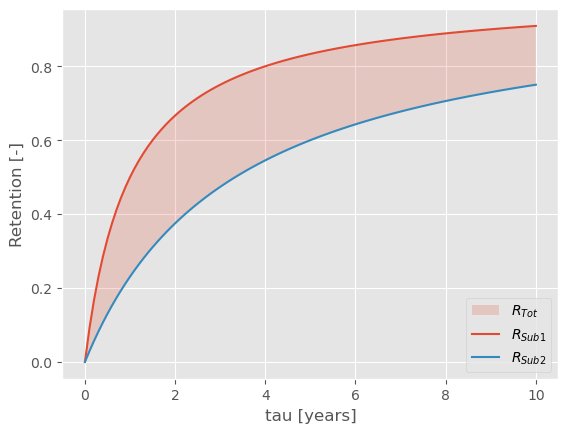

In [3]:
# Create hypothetical plots for two "fake" subfractions using "option 1"
tau = np.arange(0, 10.1, 0.1)
r_sub1 = 1 - transmission_sigma_constant(tau, sigma=1)
r_sub2 = 1 - transmission_sigma_constant(tau, sigma=0.3)

plt.fill_between(tau, r_sub1, r_sub2, alpha=0.2, label="$R_{Tot}$")
plt.plot(tau, r_sub1, ls="-", label="$R_{Sub1}$")
plt.plot(tau, r_sub2, ls="-", label="$R_{Sub2}$")
plt.xlabel("tau [years]")
plt.ylabel("Retention [-]")
plt.legend(loc="lower right");

The plot above uses "fake" data, where `Subfraction 1` is retained more than `Subfraction 2`. The shaded area indicates the range of possible values for retention of `Total`. For any specific value of $\tau$, the precise value for $R_{Tot}$ (i.e. the point within the shaded zone) is determined by the relative proportions of $R_{Sub1}$ versus $R_{Sub2}$: if `Total` mostly comprises `Subfraction 1`, total retention will be similar to the curve for $R_{Sub1}$; if `Total` is made up of equal proportions of `Subfraction 1` and `Subfraction 2`, the curve for $R_{Tot}$ would lie midway between the curves for the subfractions etc.

The key point is that, **in order to satisfy conservation of mass, retention of the total parameter must lie between the retention curves for the two subfractions**. In this notebook, we will use a combination of literature values and measured data to estimate retention curves for the different parameters in TEOTIL3. However, real data are often noisy and the Vollenweider approach is only a coarse approximation, so the uncertainty in the fitted curves may be large. **In cases where the best fit curve for `Total` violates the principle of conservation of mass, manual adjustments to the best fit parameters will be made to ensure model results remain conceptually consistent** (i.e. that `TOTN = DIN + TON` etc.)

## 3. Modelling phosphorus

The literature provides a fairly good basis for estimating TOTP retention using Vollenweider, because that is what much of the original work focused on. A review paper by [Brett and Benjamin (2008)](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2427.2007.01862.x) explored many different approaches, including the two outlined above.

 * For option 1, they found the best-fitting value was $\sigma = 0.45 \pm 0.04$
 
 * For option 2, they found $k = 1.12 \pm 0.08$ and $m = -0.53 \pm 0.03$
 
(**Note:** There is a confusing typo in Table 5 of their paper: in the equation for `Hypothesis 4`, $x_4$ should actually be $(1 + x_4)$).

Of all the methods tested, **option 2 gave the best results**, explaining 84% of the overall variance. Also, the uncertainty estimates on the parameters given in the paper are for 1 standard error, so the 95% CI (roughly 2 standard errors) includes the original Vollenweider approach where $k = 1$ and $m = -0.5$. This is the same as the method used in the original TEOTIL.

In summary, there is a good literature basis for estimating **transmission** of TOTP as

$$T_{TOTP} = \frac{1}{1 + \tau ^{0.5}}$$

which implies **retention** of TOTP is given by

$$R_{TOTP} = \frac{1}{1 + \rho ^{0.5}}$$

where

$$\rho = \frac{1}{\tau}$$

Note that **this is identical to the way TOTP is handled in the original TEOTIL model**.

Literature concerning retention of TDP and TPP is a bit sparse. TPP is typically bound to particles and therefore settles and is removed from the lake quickly compared to TDP. Some studies suggest retention of TDP is roughly 60% of retention of TOTP, and this is broadly confirmed by data for Lake Vansjø. One option for TEOTIL3 is therefore to estimate retention of TDP as

$$R_{TDP} = \frac{0.6}{1 + \rho ^{0.5}}$$

which implies transmission of TDP is

$$T_{TDP} = 0.4 + \frac{0.6}{1 + \tau ^{0.5}}$$

So far, the only paper we have found that provides a consistent dataset for TOTP, TPP and TDP is [Donald et al. (2015)](https://www.sciencedirect.com/science/article/abs/pii/S0380133015000532#!), which presents an analysis of nutrient sequestration in the Lake Winnipeg watershed of Canada.

### 3.1. Load Donald et al. dataset

**Note:** Values for retention in this dataset are given in **percent**.

In [4]:
# Empty dict to store best model results for P
results_dict = {}

In [5]:
data_fpath = r"../../data/donald_etal_2015_retention_winnipeg.csv"
df = pd.read_csv(data_fpath)
df = df.query("tau > 0")
df.sort_values("tau", inplace=True)
print(len(df), "lakes in the dataset.")
df.head()

24 lakes in the dataset.


,Lake,Lake_reservoir,Volume_m3,MeanQ_cumecs,tau,RTOTN,RTDN,RDIN,RDON,RPartN,RTOTP,RTDP,RSRP,RTPP,RTDP/RTOTP
22,Point du Bois,R,0.14,1128,0.0039,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN
4,Bearspaw,R,0.04,82,0.0155,12.0,13.0,18.0,-5.0,-1.0,24,6.0,6.0,18.0,0.25
23,Lac du Bonnet,R,0.66,1258,0.0166,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,NaN
19,Swan,L,0.01,15,0.0211,0.0,4.0,19.0,-15.0,-4.0,0,0.0,0.0,0.0,NaN
9,Codette,R,0.44,471,0.0296,15.0,2.0,1.0,1.0,13.0,47,0.0,4.0,47.0,0.00


### 3.2. TOTP

In [6]:
totp_df = df.query("0 < RTOTP < 100")[["tau", "RTOTP"]]
totp_df["RTOTP"] = totp_df["RTOTP"] / 100
totp_df["TTOTP"] = 1 - totp_df["RTOTP"]
print(len(totp_df), "lakes in the TOTP dataset.")

print("\n\nFit for 'option 1'")
totp_fit1 = fit_model(transmission_sigma_constant, totp_df, "tau", "TTOTP")

print("\n\nFit for 'option 2'")
totp_fit2 = fit_model(transmission_sigma_as_func_of_tau, totp_df, "tau", "TTOTP")

18 lakes in the TOTP dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 18
    # variables        = 1
    chi-square         = 0.85179652
    reduced chi-square = 0.05010568
    Akaike info crit   = -52.9140285
    Bayesian info crit = -52.0236568
[[Variables]]
    sigma:  4.26093204 +/- 1.26610671 (29.71%) (init = 1)
R2: 0.08


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 18
    # variables        = 2
    chi-square         = 0.53079376
    reduced chi-square = 0.03317461
    Akaike info crit   = -59.4275627
    Bayesian info crit = -57.6468192
[[Variables]]
    k:  2.29033341 +/- 0.58989131 (25.76%) (init = 1)
    m: -0.57903457 +/- 0.13832973 (23.89%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    

The "Option 2" model has the lowest AIC and highest R2. The best parameter estimates (with $1 \sigma$ standard errors) are $k = 2.3 \pm 0.6$ and $m = -0.6 \pm 0.1$. The 95% CI on the parameters includes $m = -0.5$ and (almost) $k = 1$, which corresponds to the most commonly used model for TOTP from the literature (see above). This dataset suggests that $k$ should be higher (more like 2 in this case), but the data are limited and I don't think this result is incompatible with the original Vollenweider approach of $k = 1$ and $m = -0.5$. 

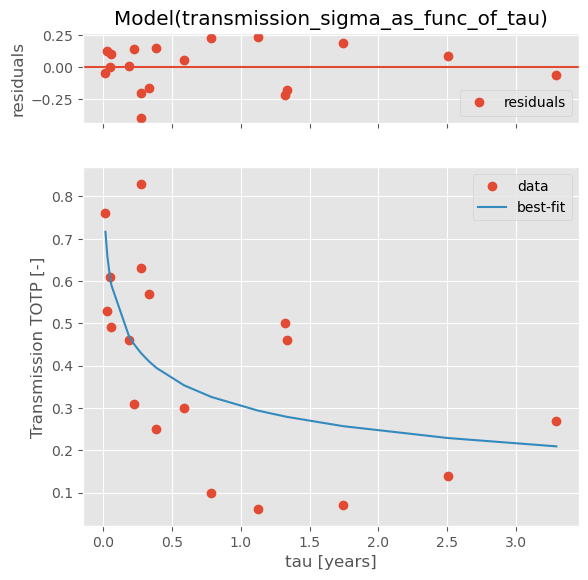

In [7]:
# Plot best fit model
totp_fit2.plot(xlabel="tau [years]", ylabel="Transmission TOTP [-]")

# Add best model to results dict for later
results_dict["TOTP"] = (totp_df, totp_fit2)

### 3.3. TDP

In [8]:
tdp_df = df.query("0 < RTDP < 100")[["tau", "RTDP"]]
tdp_df["RTDP"] = tdp_df["RTDP"] / 100
tdp_df["TTDP"] = 1 - tdp_df["RTDP"]
print(len(tdp_df), "lakes in the TDP dataset.")

print("\n\nFit for 'option 1'")
tdp_fit1 = fit_model(transmission_sigma_constant, tdp_df, "tau", "TTDP")

print("\n\nFit for 'option 2'")
tdp_fit2 = fit_model(transmission_sigma_as_func_of_tau, tdp_df, "tau", "TTDP")

9 lakes in the TDP dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 9
    # variables        = 1
    chi-square         = 0.48194842
    reduced chi-square = 0.06024355
    Akaike info crit   = -24.3442848
    Bayesian info crit = -24.1470602
[[Variables]]
    sigma:  1.96037888 +/- 0.93291666 (47.59%) (init = 1)
R2: 0.10


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 9
    # variables        = 2
    chi-square         = 0.26314977
    reduced chi-square = 0.03759282
    Akaike info crit   = -27.7903086
    Bayesian info crit = -27.3958594
[[Variables]]
    k:  1.77946942 +/- 0.56625327 (31.82%) (init = 1)
    m: -0.59004677 +/- 0.18476658 (31.31%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k,

The best fit model is "option 2", but with only 9 data points, the curve is not well constrained. Nevertheless, the parameter estimates are significantly different from zero (with 95% confidence). 

The best estimate for $m$ includes $m = -0.5$ within one standard error, while the best estimate for $k$ is around $1.8$. Note that this is lower than the estimate of $k = 2.3$ for TOTP based on the same dataset (see above) i.e. retention of TDP in these lakes is typically less than for TOTP. This is as expected, because retention for TPP is likely to be higher due to settling, so retention for the other fraction must be lower (to preserve conservation of mass - see section 2).

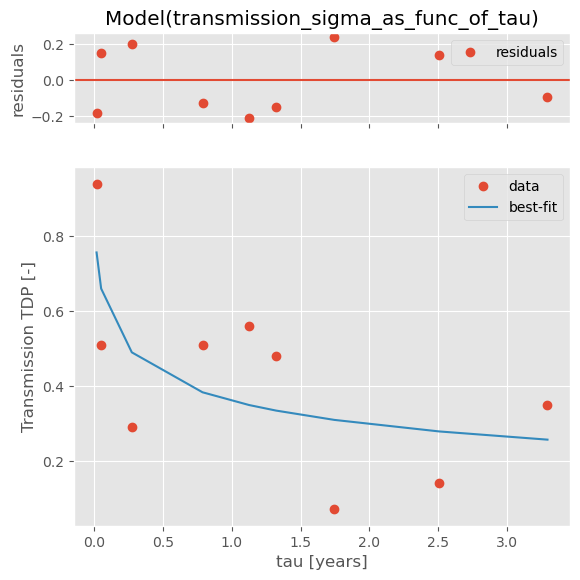

In [9]:
# Plot best fit model
tdp_fit2.plot(xlabel="tau [years]", ylabel="Transmission TDP [-]")

# Add best model to results dict for later
results_dict["TDP"] = (tdp_df, tdp_fit2)

### 3.4. TPP

In [10]:
tpp_df = df.query("0 < RTPP < 100")[["tau", "RTPP"]]
tpp_df["RTPP"] = tpp_df["RTPP"] / 100
tpp_df["TTPP"] = 1 - tpp_df["RTPP"]

# The dataset includes one very unusual lake where tau is large (>3),
# but retention is very low. This is probably due to "internal loading",
# which I do not want to include here, so I'll remove this point
tpp_df = tpp_df.query("tau < 2")

print(len(tpp_df), "lakes in the TPP dataset.")

print("\n\nFit for 'option 1'")
tpp_fit1 = fit_model(transmission_sigma_constant, tpp_df, "tau", "TTPP")

print("\n\nFit for 'option 2'")
tpp_fit2 = fit_model(transmission_sigma_as_func_of_tau, tpp_df, "tau", "TTPP")

11 lakes in the TPP dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 11
    # variables        = 1
    chi-square         = 0.69349332
    reduced chi-square = 0.06934933
    Akaike info crit   = -28.4029984
    Bayesian info crit = -28.0051032
[[Variables]]
    sigma:  3.65197691 +/- 1.44604224 (39.60%) (init = 1)
R2: -0.88


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 11
    # variables        = 2
    chi-square         = 0.31018376
    reduced chi-square = 0.03446486
    Akaike info crit   = -35.2533421
    Bayesian info crit = -34.4575516
[[Variables]]
    k:  1.34130351 +/- 0.48740992 (36.34%) (init = 1)
    m: -0.78457533 +/- 0.18148035 (23.13%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    

Unfortunately, the estimates for TPP are very poor (the best model only achieves an R2 of 15%), so I don't think I can use this for TEOTIL. Nevertheless, the "best" model is plotted below and added to the results for later.

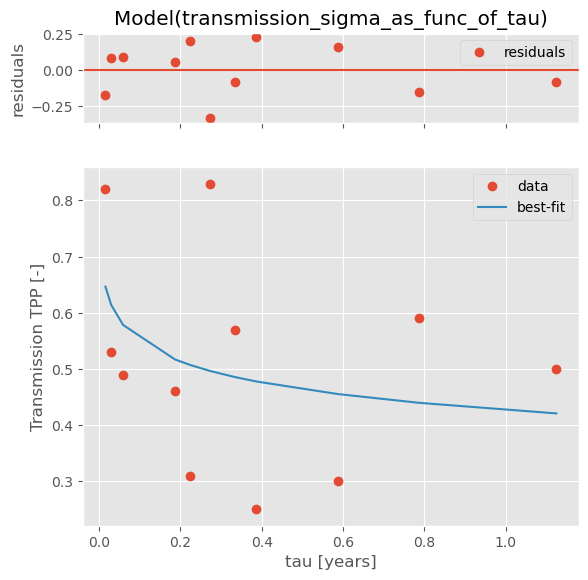

In [11]:
# Plot best fit model
tpp_fit2.plot(xlabel="tau [years]", ylabel="Transmission TPP [-]")

# Add best model to results dict for later
results_dict["TPP"] = (tpp_df, tpp_fit2)

### 4.5. Compare models for P

Results for P based on the Winnipeg dataset are poorly constrained (see the plot below). Based on this, **I do not think it is reasonable to use these curves - based on 10 to 15 lakes in Canada - as the basis for retention calculations TEOTIL3**. However, since this is the only dataset we have found that considers subfractions of P in a consistent way, we'll need to take something from it if possible.

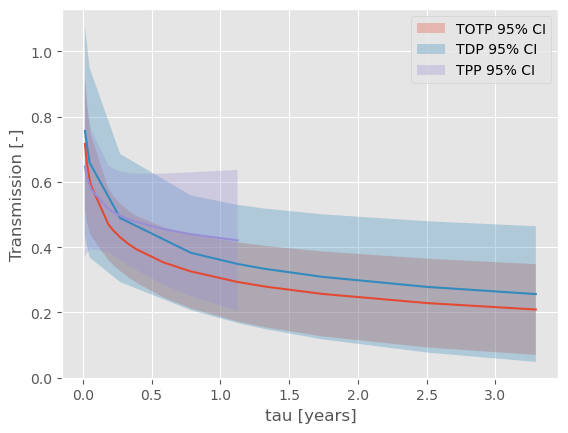

In [12]:
for key, val in results_dict.items():
    raw_df, fit_res = val

    # Get 2-sigma (=95%) CI
    conf_arr = fit_res.eval_uncertainty(sigma=2)

    # Plot
    plt.fill_between(
        raw_df["tau"],
        fit_res.best_fit - conf_arr,
        fit_res.best_fit + conf_arr,
        alpha=0.3,
        label=f"{key} 95% CI",
    )
    plt.plot(raw_df["tau"], fit_res.best_fit)

plt.legend()
plt.xlabel("tau [years]")
plt.ylabel("Transmission [-]");

For TOTP and TDP, the parameter estimates for $m$ from the Winnipeg dataset are compatible with the broader literature (where $ = -0.5$), but the estimates for $k$ seem high: for TOTP, the Winnipeg dataset suggests $k = 2.3$, compared to $k \approx 1$ from broader studies. However, the *relative* values for $k$ from this dataset seem reasonable, in the sense that the lower end of the $2 \sigma$ (95%) CI for $k$ from this dataset gives $k \approx 1$ for TOTP and $k \approx 0.5$ for TDP. These values are at the extreme limit of what is acceptable based on the Winnipeg data, but they seem more compatible with values taken from the wider literature (at least, for TOTP). Although it is not entirely satisfactory, as a pragmatic solution I propose using

 * $k = 1$ and $m = -0.5$ for **TOTP**
 
 * $k = 0.5$ and $m = -0.5$ for **TDP**
 
This leaves the problem of how to handle TPP, since the results from the statistical analysis above are so poor as to be unusable and there is little information available in the wider literature. A large proportion of TPP is bound to settling sediments, which should be removed from the system rapidly. I therefore expect $R_{TPP}$ to be high. This is confirmed by the data for TOTP and TDP from Donald et al. (above), which show that retention of TDP is typically lower than for TOTP (and therefore retention of TPP must be higher to conserve mass). Unfortunately, fitting the TPP data from Donald et al. directly yields a result that contradicts this (but the model fit is so poor as to be essentially meaningless).

As a pragmatic solution, I propose keeping $m = -0.5$ for TPP and fixing $k$ so that the curve for TOTP lies approximately in the middle of the curves for TDP and TPP. An easy way to achieve the desired effect is to set $k \approx 2$ for TPP. As a sense check, measured data from the Storefjorden basin of Lake Vannsjø near moss suggest that, on average, around **30% of TDP**, **50% of TOTP** and **66% of TPP** are retained in the lake. Residence time estimates for this basin are around **11 months**, which agrees fairly well with the proposed curves (see plot below).

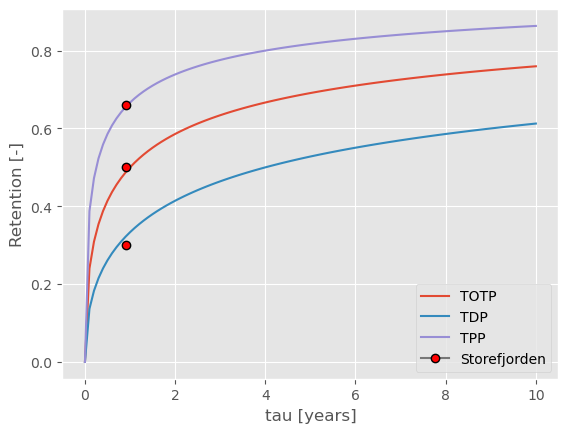

In [13]:
# TOTP
ret = 1 - transmission_sigma_as_func_of_tau(tau, k=1, m=-0.5)
plt.plot(tau, ret, ls="-", label=f"TOTP")

# TDP
ret = 1 - transmission_sigma_as_func_of_tau(tau, k=0.5, m=-0.5)
plt.plot(tau, ret, ls="-", label=f"TDP")

# TPP
ret = 1 - transmission_sigma_as_func_of_tau(tau, k=2, m=-0.5)
plt.plot(tau, ret, ls="-", label=f"TPP")

# Plot data from Storefjorden
plt.plot(
    11 / 12,
    0.3,
    marker="o",
    markerfacecolor="r",
    markeredgecolor="k",
    label="Storefjorden",
)
plt.plot(11 / 12, 0.5, marker="o", markerfacecolor="r", markeredgecolor="k")
plt.plot(11 / 12, 0.66, marker="o", markerfacecolor="r", markeredgecolor="k")

plt.xlabel("tau [years]")
plt.ylabel("Retention [-]");
plt.legend();

## 4. Modelling nitrogen

The literature for N is not as good as that for P. The old TEOTIL model used $R_{TOTN} = 0.2 R_{TOTP}$ based on the work of [Holtan (1991)](https://niva.brage.unit.no/niva-xmlui/handle/11250/206295?locale-attribute=en). However, this study only considers a small number of lakes in South-eastern Norway and the relationship doesn't seem very robust even for these. This approach also implies that retention of TOTN can never be higher than 0.2, which seems low. Hopefully we can improve on this by adding more data. 

The best thing we've found so far in the recent literature is the dataset from [Steingruber (2020)](https://www.sciencedirect.com/science/article/pii/S0304380019303618), which Leah has extracted and saved to the JupyterHub. Column names in the dataset are as follows:

 * N° denotes the lake number
 * z is the mean depth (m)
 * tau is the residence time (yr)
 * RTOTN the relative retention of TOTN (proportion of incoming TOTN)
 * RDIN the relative retention of DIN (proportion of incoming DIN)
 * LTOTN the areal TOTN load to the lake (g m-2 yr-1)
 * LDIN the areal DIN load to the lake (g m-2 yr-1)
 * CTOTP the in-lake concentration of TOTP (ug/l I think; paper gets this mixed up)
 * TOTN/TOTP the weight ratio between in-lake concentrations of TOTN and TOTP
 
### 3.1. Load Steingruber dataset

In [14]:
# Empty dict to store best model results for N
results_dict = {}

In [15]:
data_fpath = r"../../data/steingruber_2020_lake_N_budgets_updated.csv"
countries_to_keep = ["Norway", "Finland", "Sweden", "Canada"]
df = pd.read_csv(data_fpath)
df = df.query("Location in @countries_to_keep")
df = df.query("tau > 0")

# The same lake is often present multiple times for different periods, perhaps
# with different tau, but often not. Average so we have just one value per lake
df = df.groupby("Name").mean().reset_index()
df.sort_values("tau", inplace=True)

# Add L_out, calculated using reported retention and areal input load
df["LTOTN_out"] = df["LTOTN"] * (1 - df["RTOTN"])
df["LDIN_out"] = df["LDIN"] * (1 - df["RDIN"])

# Add estimates for TON
df["LTON"] = df["LTOTN"] - df["LDIN"]

# Set any negative values to small numbers
df.loc[df["LTON"] <= 0, "LTON"] = 0.01
df["LTON_out"] = df["LTOTN_out"] - df["LDIN_out"]
df.loc[df["LTON_out"] <= 0, "LTON_out"] = 0.01

# Calculate TON retention
df["RTON"] = 1 - df["LTON_out"] / df["LTON"]

print(len(df), "lakes in the dataset.")
df.describe()

100 lakes in the dataset.


,N°,z,tau,RTOTN,RDIN,LTOTN,LDIN,LDIN/LTOTN,CTOTP,TOTN/TOTP,LTOTN_out,LDIN_out,LTON,LTON_out,RTON
count,100.000000,100.000000,100.000000,87.000000,29.000000,84.000000,25.000000,16.000000,97.000000,82.000000,84.000000,25.000000,16.000000,16.000000,16.000000
mean,90.350000,8.826000,2.006150,0.364425,0.505862,51.708333,6.720000,0.566250,68.483505,37.128049,43.195387,5.249200,4.813125,4.496250,-1.859496
std,64.510687,15.155648,6.169728,0.231758,0.319861,144.090087,10.628264,0.180624,143.594635,33.061466,135.215351,9.488761,6.451570,6.212122,8.040654
min,1.000000,0.800000,0.005000,-0.110000,-0.220000,2.000000,1.000000,0.090000,0.200000,3.000000,0.450000,0.020000,0.010000,0.330000,-32.000000
25%,47.750000,3.275000,0.200000,0.190000,0.240000,4.750000,1.000000,0.465000,8.000000,14.000000,1.920000,0.270000,1.000000,0.772500,0.038542
50%,72.500000,5.250000,0.650000,0.390000,0.570000,18.000000,2.000000,0.580000,20.000000,28.000000,9.965000,0.760000,1.000000,1.135000,0.127083
75%,152.500000,8.925000,1.800000,0.510000,0.730000,34.000000,4.000000,0.712500,60.000000,45.750000,26.040000,3.660000,6.750000,5.835000,0.277500
max,221.000000,138.000000,60.000000,0.910000,0.980000,1026.000000,43.000000,0.790000,1160.000000,162.000000,995.220000,35.260000,24.000000,22.260000,0.590000


**Note:** There is a very different distribution of residence times between the Steingruber dataset and the Norwegian lakes in TEOTIL:

 * **IQR TEOTIL lakes:** 0.003 - 0.045
 * **IQR Steingruber data:** 0.1 - 0.3. And min value is 0.005 i.e. higher than the 25th percentile of TEOTIL lakes.

It Would be good to add some low tau lakes to this dataset. Maybe Jens Fölster at SLU can point us towards some data from Sweden?

### 4.2. TOTN

In [16]:
# Get data for TOTN
totn_df = df[["tau", "RTOTN"]].dropna(how="any")

# Drop negative retention values
totn_df = totn_df.query("RTOTN > 0")

# Remove one extreme outlier with tau ~60 years
totn_df = totn_df.query("tau < 50")

# Calculate transmission
totn_df["TTOTN"] = 1 - totn_df["RTOTN"]

print(len(totn_df), "lakes in the TOTN dataset.")

print("\n\nFit for 'option 1'")
totn_fit1 = fit_model(transmission_sigma_constant, totn_df, "tau", "TTOTN")

print("\n\nFit for 'option 2'")
totn_fit2 = fit_model(transmission_sigma_as_func_of_tau, totn_df, "tau", "TTOTN")

82 lakes in the TOTN dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 82
    # variables        = 1
    chi-square         = 4.27339089
    reduced chi-square = 0.05275791
    Akaike info crit   = -240.253552
    Bayesian info crit = -237.846833
[[Variables]]
    sigma:  0.71056624 +/- 0.09713105 (13.67%) (init = 1)
R2: -0.06


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 2
    chi-square         = 2.78730079
    reduced chi-square = 0.03484126
    Akaike info crit   = -273.294937
    Bayesian info crit = -268.481499
[[Variables]]
    k:  0.74567157 +/- 0.06938204 (9.30%) (init = 1)
    m: -0.63488541 +/- 0.07369145 (11.61%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    

Both models are highly significant but the second, "option 2", has a substantially lower AIC and a better R2 (although it's still only around 30%).

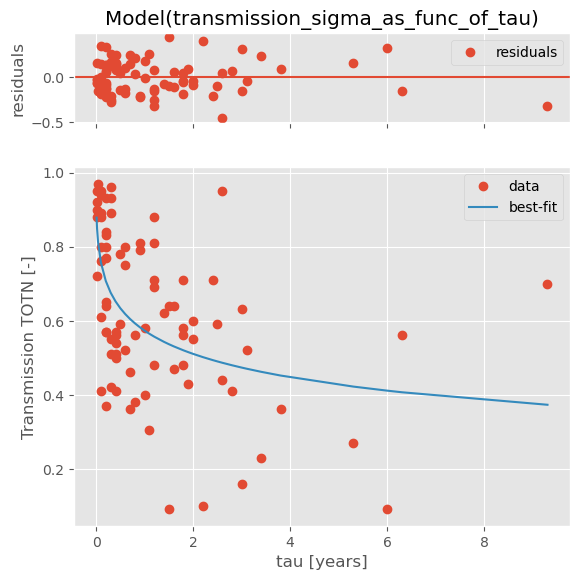

In [17]:
# Plot best fit model
totn_fit2.plot(xlabel="tau [years]", ylabel="Transmission TOTN [-]")

# Add best model to results dict for later
results_dict["TOTN"] = (totn_df, totn_fit2)

This model seems statistically valid and the fit is reasonable, but the results are uncertain due to the amount of noise in the dataset. Having said that, I have tried removing obvious outliers and other possibly dubious data points and refitting the model, and the best parameters *do* seem remarkably robust. The best parameter estimates are $k = 0.75 \pm 0.07$ and $m = -0.63 \pm 0.07$. Note that the 95% CI for $m$ (roughly two standard errors) just about includes $m = -0.5$, so the main difference between TOTN and TOTP based on these data is that $k = 0.75$ for TOTN, versus $k = 1$ for TOTP.

**Note that these parameters imply much higher retention of TOTN than in the original model!**

### 4.3. DIN

In [18]:
# Get data for DIN
din_df = df[["tau", "RDIN"]].dropna(how="any")

# Drop negative retention values
din_df = din_df.query("RDIN > 0")

# Remove one extreme outlier with tau ~60 years
din_df = din_df.query("tau < 50")

# Calculate transmission
din_df["TDIN"] = 1 - din_df["RDIN"]

print(len(din_df), "lakes in the DIN dataset.")

print("\n\nFit for 'option 1'")
din_fit1 = fit_model(transmission_sigma_constant, din_df, "tau", "TDIN")

print("\n\nFit for 'option 2'")
din_fit2 = fit_model(transmission_sigma_as_func_of_tau, din_df, "tau", "TDIN")

28 lakes in the DIN dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 28
    # variables        = 1
    chi-square         = 0.46732178
    reduced chi-square = 0.01730821
    Akaike info crit   = -112.602368
    Bayesian info crit = -111.270164
[[Variables]]
    sigma:  0.95917223 +/- 0.12809944 (13.36%) (init = 1)
R2: 0.80


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 28
    # variables        = 2
    chi-square         = 0.46261526
    reduced chi-square = 0.01779289
    Akaike info crit   = -110.885793
    Bayesian info crit = -108.221384
[[Variables]]
    k:  0.97494917 +/- 0.13097006 (13.43%) (init = 1)
    m: -0.06953910 +/- 0.13285861 (191.06%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C

Compared to the results for TOTN, results for DIN seem very nice (R2 is around 80%).

These two models give similar results, but in this case "option 1" (the simpler model) has a slightly lower AIC. This is because in the second model the parameter $m$ is not significantly different from zero, so the two models essentially reduce to the same thing i.e. the best model here is "pure" Vollenweider with a first order removal term. 

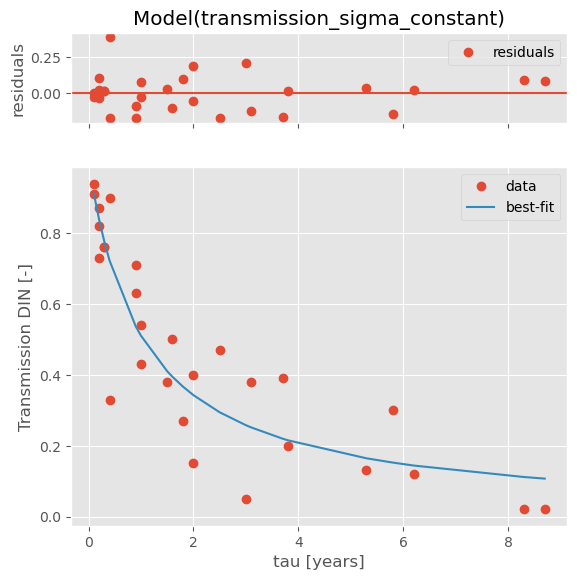

In [19]:
# Plot best fit model
din_fit1.plot(xlabel="tau [years]", ylabel="Transmission DIN [-]")

# Add best model to results dict for later
results_dict["DIN"] = (din_df, din_fit1)

For DIN, the best fit is achieved using "option 1" with $\sigma = 1$.

### 4.4. TON

In [20]:
# Get data for DON
ton_df = df[["tau", "RTON"]].dropna(how="any")

# Drop negative retention values
ton_df = ton_df.query("RTON > 0")

# Remove one extreme outlier with tau ~60 years
ton_df = ton_df.query("tau < 50")

# Calculate transmission
ton_df["TTON"] = 1 - ton_df["RTON"]

print(len(ton_df), "lakes in the TON dataset.")

print("\n\nFit for 'option 1'")
ton_fit1 = fit_model(transmission_sigma_constant, ton_df, "tau", "TTON")

print("\n\nFit for 'option 2'")
ton_fit2 = fit_model(transmission_sigma_as_func_of_tau, ton_df, "tau", "TTON")

12 lakes in the TON dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 12
    # variables        = 1
    chi-square         = 0.14101717
    reduced chi-square = 0.01281974
    Akaike info crit   = -51.3253629
    Bayesian info crit = -50.8404562
[[Variables]]
    sigma:  0.16887306 +/- 0.03260570 (19.31%) (init = 1)
R2: 0.54


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 12
    # variables        = 2
    chi-square         = 0.14084467
    reduced chi-square = 0.01408447
    Akaike info crit   = -49.3400517
    Bayesian info crit = -48.3702384
[[Variables]]
    k:  0.15932346 +/- 0.06526094 (40.96%) (init = 1)
    m:  0.05756884 +/- 0.36870380 (640.46%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    

For TON, the best fit is with "option 1" with $\sigma = 0.17 \pm 0.03$.

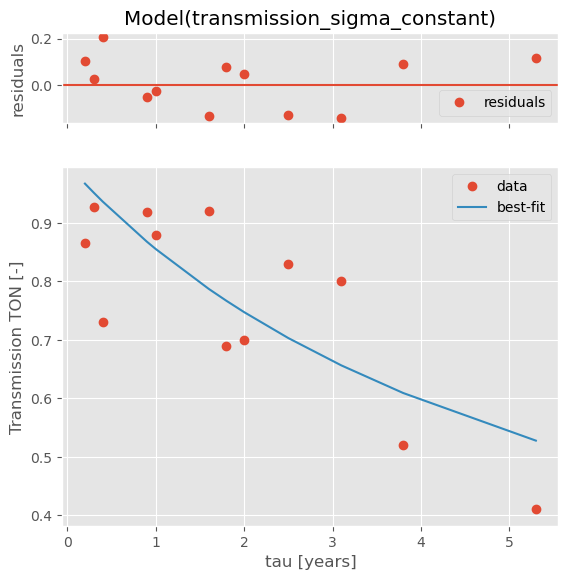

In [21]:
# Plot best fit model
ton_fit1.plot(xlabel="tau [years]", ylabel="Transmission TON [-]")

# Add best model to results dict for later
results_dict["TON"] = (ton_df, ton_fit1)

### 4.5. Compare models for N

Results for N generally seem better than for P - mostly because the N dataset is larger and encompasses a broader range of lakes from different regions. The code below plots the three best fit curves, together with 95% confidence intervals. Although the curve for TOTN does not quite plot between the curves for DIN and TON for all values of tau, the differences are small and the overall pattern looks sensible. Based on these curves, I think it is reasonable to use the best fit Vollenweider parameters for DIN and TON, and to allow retention of TOTN lie between these two curves (as explained in section 2).

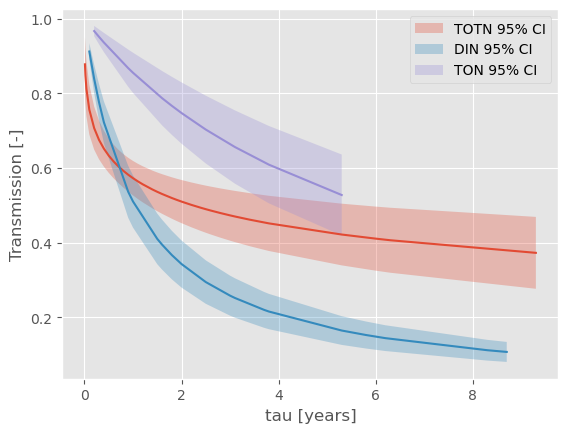

In [22]:
for key, val in results_dict.items():
    raw_df, fit_res = val

    # Get 2-sigma (=95%) CI
    conf_arr = fit_res.eval_uncertainty(sigma=2)

    # Plot
    plt.fill_between(
        raw_df["tau"],
        fit_res.best_fit - conf_arr,
        fit_res.best_fit + conf_arr,
        alpha=0.3,
        label=f"{key} 95% CI",
    )
    plt.plot(raw_df["tau"], fit_res.best_fit)

plt.legend()
plt.xlabel("tau [years]")
plt.ylabel("Transmission [-]");

## 5. Suspended sediment (SS)

In the literature concerning SS, retention is usually referred to as the "**sediment trap efficiency**". There are many references on this topic - mostly in engineering journals with a focus on reservoir silting and sedimentation. Settling velocity and resuspension are the dominant processes controlling sediment retention. Since these are primarily physical (rather than biological or chemical) processes, we might expect them to behave similarly across a broad range of lake types and locations (climate etc.). Particle grain size is one of the key factors controlling rates of settling and resuspension, so some models for specific lakes or reservoirs use separate parameter sets for different particle size fractions. This is not appropriate for TEOTIL, so hopefully we can achieve reasonable performance using a single model for all lakes.

The classic approach for modelling SS in lakes and reservoirs was proposed by [Brune (1953)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/TR034i003p00407). This model is of the form

$$R_{SS} = 1 - \frac{0.05 \alpha}{\tau ^{0.5}}$$

In other words, **transmission** is given by

$$T_{SS} = \frac{0.05 \alpha}{\tau ^{0.5}}$$

Many modern studies still use the equation above. Note, however, that $T_{SS} \to \infty$ as $\tau \to 0$, so this equation will predict $T_{SS} \gt 1$ for very small values of $\tau$. [Heinemann (1983)](https://onlinelibrary.wiley.com/doi/10.1111/j.1752-1688.1981.tb01304.x) cited an alternative approach that may perform better

$$R_{SS} = \frac{\tau}{0.012 + 1.02 \tau}$$

According to the paper, this comes from the textbook [Applied hydraulics in Engineering by Morris (1963)](https://www.amazon.com/Applied-Hydraulics-Engineering-Henry-Morris/dp/0471066699). I do not have access to this textbook, but the equation is just a rearranged version of Vollenweider, which seems promising for TEOTIL. Assuming $1.02 \approx 1$ and allowing 0.012 to vary as an adjustable parameter gives 

$$R_{SS} = \frac{\tau}{\alpha + \tau}$$

If we divide top and bottom by $\alpha \tau$ and let $\sigma = 1 / \alpha$, we can re-express this as

$$R_{SS} = \frac{\sigma}{\sigma + \rho}$$

(where $\rho$ is as defined above). This is the classic version of the Vollenweider equation (derived e.g. [here](https://nivanorge.github.io/teotil2/pages/05_retention.html)), where transmission is modelled as

$$T_{SS} = \frac{1}{1 + \sigma \tau}$$

If we take the value of $\alpha = 0.012$ from Heinemann (1983), this gives $\sigma \approx 83$. In other words, SS is removed from the system *very* rapidly compared to e.g. DIN (where $\sigma \approx 1$ based on the analysis above).

### 4.1. Retention data for SS

The paper by [Brune (1953)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/TR034i003p00407) contains data for 40 reservoirs and [Heinemann (1983)](https://onlinelibrary.wiley.com/doi/10.1111/j.1752-1688.1981.tb01304.x) has data for an additional 20. There is also a more recent paper from [Tan et al. (2019)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6819860/), which includes data for another 20 reservoirs located along the Yangtze River in China. I have compiled these datasets into a CSV for further analysis (hosted online [here](https://github.com/NIVANorge/teotil3/blob/main/data/sed_retention_data.csv); note that the PDFs for Brune and Heinemann were obtained by Leah - see e-mail received 12.10.2022).

The combined dataset comprises data for 80 reservoirs located in the USA and China, collected over a period of more than 70 years. If we can fit a reasonably robust model to this dataset, I think we can assume the parameters are sufficiently stable to be used in the new TEOTIL model.

In [23]:
# Read SS retention data
data_fpath = r"../../data/sed_retention_data.csv"
ss_df = pd.read_csv(data_fpath)

# Calculate transmission
ss_df["TSS"] = 1 - ss_df["RSS"]

print(len(ss_df), "lakes in the SS dataset.")
ss_df.head()

80 lakes in the SS dataset.


,lake_id,reference,tau,RSS,TSS
0,1,Brune (1953),0.0016,0.000,1.000
1,2,Brune (1953),0.0029,0.023,0.977
2,3,Brune (1953),0.0041,0.058,0.942
3,4,Brune (1953),0.0051,0.305,0.695
4,5,Brune (1953),0.0051,0.297,0.703


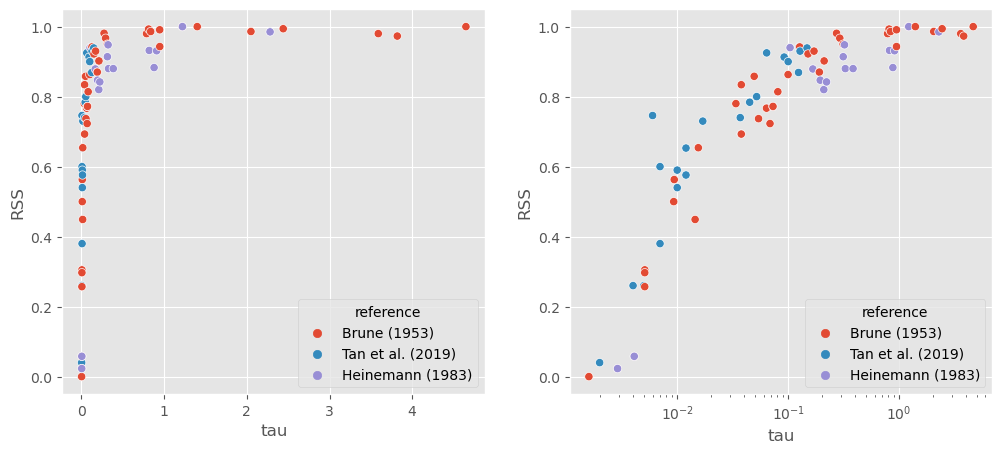

In [24]:
# Sort for plotting
ss_df.sort_values("tau", inplace=True)

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
g1 = sn.scatterplot(
    data=ss_df, x="tau", y="RSS", hue="reference", ax=axes[0]
)
g2 = sn.scatterplot(
    data=ss_df, x="tau", y="RSS", hue="reference", ax=axes[1]
)
sn.move_legend(g2, "lower right")
axes[1].set_xscale("log")

This dataset seems remarkably consistent and shows very clearly that sediment is removed quickly from all but the smallest lakes. It should be possible to fit a good model here.

### 5.2. Models for SS

In addition to the Vollenwieder models introduced at the start of this notebook, I also want to fit the original model from Brune (1953) to see if it is any better.

In [25]:
def transmission_brune_1953(tau, alpha=1):
    return 0.05 * alpha / (tau**0.5)

In [26]:
print("\n\nFit for 'option 1'")
ss_fit1 = fit_model(transmission_sigma_constant, ss_df, "tau", "TSS")

print("\n\nFit for 'option 2'")
ss_fit2 = fit_model(transmission_sigma_as_func_of_tau, ss_df, "tau", "TSS")

print("\n\nFit for 'Brune (1953)'")
ss_fit3 = fit_model(transmission_brune_1953, ss_df, "tau", "TSS")



Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 80
    # variables        = 1
    chi-square         = 0.66603134
    reduced chi-square = 0.00843078
    Akaike info crit   = -381.075615
    Bayesian info crit = -378.693588
[[Variables]]
    sigma:  88.2175928 +/- 6.55889024 (7.43%) (init = 1)
R2: 0.90


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 80
    # variables        = 2
    chi-square         = 0.66151099
    reduced chi-square = 0.00848091
    Akaike info crit   = -379.620426
    Bayesian info crit = -374.856373
[[Variables]]
    k:  70.4010834 +/- 19.9127528 (28.28%) (init = 1)
    m: -0.05063741 +/- 0.06431651 (127.01%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, m) =  0.966
R2: 0.90


Fi

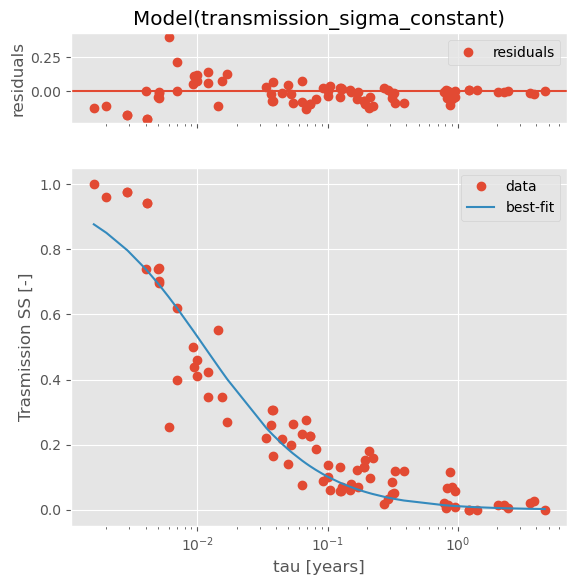

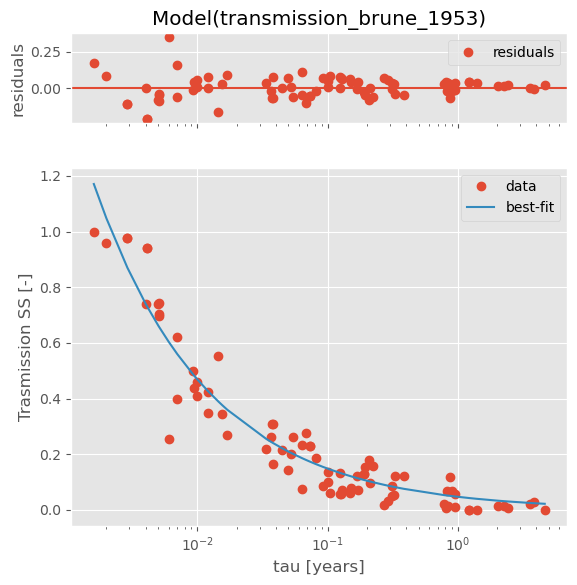

In [27]:
# Plot fit for best Vollenweider model
ss_fit1.plot(xlabel="tau [years]", ylabel="Trasmission SS [-]")
plt.xscale("log")

# Plot for Brune model
ss_fit3.plot(xlabel="tau [years]", ylabel="Trasmission SS [-]")
plt.xscale("log")

Of the two Vollenweider models, the simplest "pure" approach gives the best results, with $R^2 \approx 90\%$ and $\sigma \approx 90$. This is very similar to the models presented by Morris (1963) and Heinemann (1983), and overall the fit is very good.

The Brune model has a lower AIC than the best Vollenweider model and the $R^2$ is also slightly higher (92%). Perhaps most importantly, this model seems to fit the data better for lakes with short residence times, where the Vollenweider approach tends to underestimate transmission. However, the Brune model will predict $T_{SS} > 1$ for values of $\tau < 0.05 \alpha^2$, which is approximately 0.002 years for the best fit model here. Around 20% of the lakes in the Norwegian dataset have a residence time less than this, so we would need to place a limit of 1 on $T_{SS}$ for small lakes. By contrast, the physical basis of Vollenweider limits $T$ to a maximum of 1. 

**Either of these two models should be good enough for TEOTIL3**. Using the Vollenweider approach is slightly simpler, as it is the same method used for other parameters in TEOTIL. It is also a more elegant solution, since it does not require capping the function at 1. However, Brune seems to perform slightly better for lakes with short residence times, which are common in Norway (and where Vollenweider seems to underestimate transmission based on the dataset here).

## 6. TOC

For TOC, authors such as Dillon and Molot have estimated lake retention as a function of areal discharge, and there is widespread agreement that water residence time is a dominant factor controlling DOC degradation and removal. However, we haven't found any actual Vollenweider-style representations of retention to base parameter values on. The most useful thing we have found so far is the supplementary data to [Evans et al. (2017)](https://www.nature.com/articles/ngeo3051) (a PDF of the paper is archived [here](https://nora.nerc.ac.uk/id/eprint/518436/1/N518436PP.pdf), but the supplementary data is downloaded from the publisher's website). Although the paper focuses on DOC, we will assume the same parameters apply for TOC. This is reasonable for upland/natural areas, but may not be appropriate more areas influenced by human activities.

**Note:** Leah has added the Langtjern DOC budget to this dataset, to have one extra Norwegian data point.

### 6.1 Load Evans data

In [28]:
data_fpath = r"../../data/evans_2017_doc_retention_cleaned.csv"
df = pd.read_csv(data_fpath)
countries_to_keep = ["Norway", "Finland", "Sweden", "Canada"]
df = df.query("country in @countries_to_keep")
df.sort_values("tau", inplace=True)
df.head()

,name,country,type,nutrient_status,tau,DOC_in,DOC_out,TDOC,RDOC,Notes,DOC_type
62,Wascana,Canada,Reservoir,Eutrophic,0.01,0.73,0.73,1.00,0.00,NaN,Balanced
22,Ekojarvi,Finland,Lake,Oligotrophic,0.07,2.79,2.52,0.90,0.10,NaN,DOC sink
73,Woods Pond,Canada,Lake,Mesotrophic,0.08,73.89,83.96,1.14,-0.14,NaN,Source
51,Lundetjenn,Norway,Lake,Oligotrophic,0.10,8.32,8.28,0.99,0.01,NaN,Balanced
27,Røynelandsvatn,Norway,Lake,Oligotrophic,0.10,6.37,5.49,0.86,0.14,NaN,DOC sink


### 6.2 Fit TOC

In [29]:
# Get data for TOC
toc_df = df[["tau", "RDOC"]].dropna(how="any")

# Drop negative retention values
toc_df = toc_df.query("RDOC > 0")

# Calculate transmission
toc_df["TDOC"] = 1 - toc_df["RDOC"]

print(len(toc_df), "lakes in the TOC dataset.")

print("\n\nFit for 'option 1'")
toc_fit1 = fit_model(transmission_sigma_constant, toc_df, "tau", "TDOC")

print("\n\nFit for 'option 2'")
toc_fit2 = fit_model(transmission_sigma_as_func_of_tau, toc_df, "tau", "TDOC")

39 lakes in the TOC dataset.


Fit for 'option 1'
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 39
    # variables        = 1
    chi-square         = 1.29874631
    reduced chi-square = 0.03417753
    Akaike info crit   = -130.684327
    Bayesian info crit = -129.020765
[[Variables]]
    sigma:  0.34650190 +/- 0.05174811 (14.93%) (init = 1)
R2: -0.09


Fit for 'option 2'
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 39
    # variables        = 2
    chi-square         = 0.64471920
    reduced chi-square = 0.01742484
    Akaike info crit   = -155.997580
    Bayesian info crit = -152.670457
[[Variables]]
    k:  0.57260120 +/- 0.05962680 (10.41%) (init = 1)
    m: -0.62863558 +/- 0.07985587 (12.70%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    

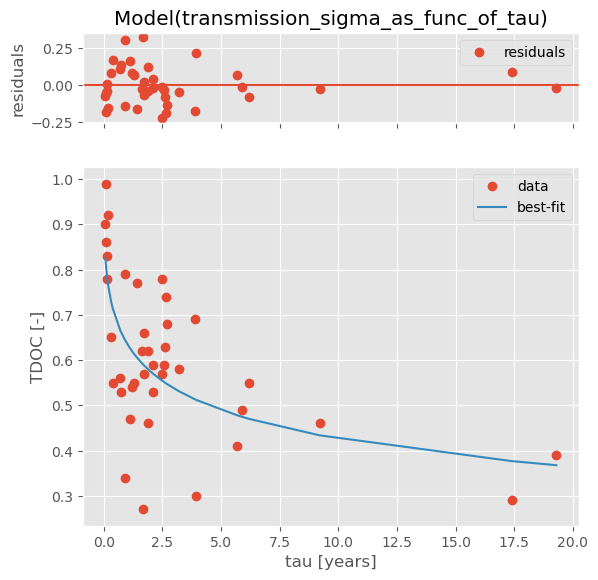

In [30]:
# Plot fit
toc_fit2.plot(xlabel="tau [years]", ylabel="TDOC [-]");

The "option 2" model fits best, but there is lots of scatter. Fitted coefficients are  $k = 0.6$ and $m = -0.6$.

## 7. Summary

### 7.1. P

 * **Transmission of TDP** will be modelled as 
 
$$T_{TDP} = \frac{1}{1 + 0.5 \tau ^{0.5}}$$
 
 * **Transmission of TPP** will be modelled as 
 
$$T_{TPP} = \frac{1}{1 + 2 \tau ^{0.5}}$$
 
 * To preserve concservation of mass, **transmission of TOTP** will be modelled as a weighted sum of the two functions above (see section 2). However, the functions for TDP and TPP have been constructed such that typical retention for TOTP will broadly follow the well-established relationship
 
$$T_{TOTP} = \frac{1}{1 + \tau ^{0.5}}$$

### 7.2. N

 * **Transmission of DIN** will be modelled as 
 
$$T_{DIN} = \frac{1}{1 + \tau}$$
 
 * **Transmission of TON** will be modelled as 
 
$$T_{TON} = \frac{1}{1 + 0.2 \tau}$$

 * To preserve concservation of mass, **transmission of TOTN** will be modelled as a weighted sum of the two functions above (see section 2). However, the functions for DIN and TON have been constructed such that typical retention for TOTN will be broadly compatible with the relationship
 
$$T_{TOTN} = \frac{1}{1 + 0.75 \tau ^{0.4}}$$

### 7.3. SS

 * **Transmission of SS** will be modelled using either a Vollenweider model (left) or a Brune model (right). The first is more consistent with the rest of TEOTIL and has a stronger physical basis; the second gives a slightly better fit to empirical data. To begin with, I will try the Vollenweider model.
 
$$T_{SS} = \frac{1}{1 + 90 \tau} \qquad or \qquad T_{SS} = \frac{0.0475}{\tau ^{0.5}}$$

### 7.4. TOC

 * **Transmission of TOC** will be modelled as
 
$$T_{TOC} = \frac{1}{1 + 0.6 \tau ^{0.4}}$$
 

These curves are illustrated on the plots below.

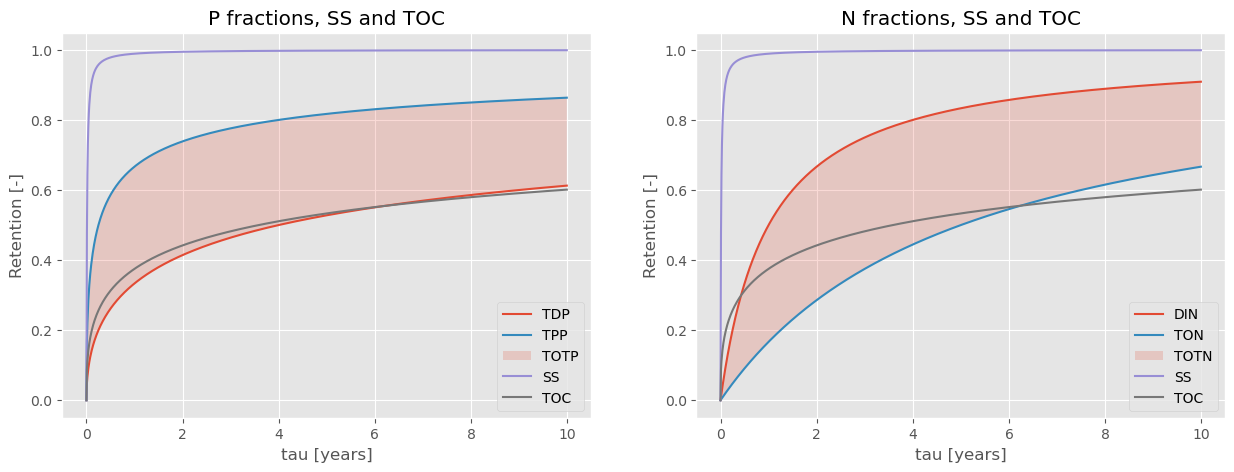

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
tau = np.arange(0, 10, 0.01)

# P
ret_tdp = 1 - transmission_sigma_as_func_of_tau(tau, k=0.5, m=-0.5)
ret_tpp = 1 - transmission_sigma_as_func_of_tau(tau, k=2, m=-0.5)
axes[0].plot(tau, ret_tdp, ls="-", label=f"TDP")
axes[0].plot(tau, ret_tpp, ls="-", label=f"TPP")
axes[0].fill_between(tau, ret_tdp, ret_tpp, alpha=0.2, label="TOTP")

# N
ret_din = 1 - transmission_sigma_constant(tau, sigma=1)
ret_ton = 1 - transmission_sigma_constant(tau, sigma=0.2)
axes[1].plot(tau, ret_din, ls="-", label=f"DIN")
axes[1].plot(tau, ret_ton, ls="-", label=f"TON")
axes[1].fill_between(tau, ret_din, ret_ton, alpha=0.2, label="TOTN")

# SS on both axes
ret_ss = 1 - transmission_sigma_constant(tau, sigma=90)
axes[0].plot(tau, ret_ss, ls="-", label="SS")
axes[1].plot(tau, ret_ss, ls="-", label="SS")

# TOC on both axes
ret_toc = 1 - transmission_sigma_as_func_of_tau(tau, k=0.6, m=-0.6)
axes[0].plot(tau, ret_toc, ls="-", label="TOC")
axes[1].plot(tau, ret_toc, ls="-", label="TOC")

axes[0].set_xlabel("tau [years]")
axes[0].set_ylabel("Retention [-]")
axes[0].legend(loc="lower right")
axes[0].set_title("P fractions, SS and TOC")

axes[1].set_xlabel("tau [years]")
axes[1].set_ylabel("Retention [-]")
axes[1].legend(loc="lower right")
axes[1].set_title("N fractions, SS and TOC");